In [1]:
# -!- coding: utf-8 -!-
## load library
%matplotlib inline

import pandas as pd
import numpy as np
import gensim
from gensim.models import word2vec, Word2Vec
from scipy import stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud

FONT_PATH = './util_files/font/simkai.ttf'

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action = 'ignore')

import csv, os, sys, math
import linecache
import pickle
import random
import datetime

#簡轉繁用 
#https://pypi.python.org/pypi/hanziconv/0.2.1
from hanziconv import HanziConv 

#https://stackoverflow.com/questions/14519177/python-exception-handling-line-number
def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print ('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(filename, lineno, line.strip(), exc_obj))

In [2]:
# READ IPA DATA
ethnicsdata = pd.read_csv('./IPA/withChiEthics.csv', parse_dates = True)

In [3]:
#Read files

with open('./pkl_data/special_word_dict', 'rb') as handle:
    special_word_dict = pickle.loads(handle.read())

with open('./pkl_data/Totalname_list', 'rb') as handle:
    Totalname_list = pickle.loads(handle.read())
    
with open('./pkl_data/son_in_list', 'rb') as handle:
    son_in_list = pickle.loads(handle.read())
    
with open('./pkl_data/mu_in_list', 'rb') as handle:
    mu_in_list = pickle.loads(handle.read())

In [4]:
ethnicsdata['Ethnic'].value_counts()

Hokkien                            9676
Cantonese                          5525
Teochew                            4076
Hakka                              3012
Hokkien/Teochew                    2617
Mandarin                           1884
Hokkien/Teochew/Hainanese/Hakka    1814
Others                              479
Hokkien/Hakka                       464
Hokchew                             290
Foochow                             280
Korean                              219
Hainanese                           202
Cantonese/Hakka                     149
Hokkien/Teochew/Cantonese/Hakka      55
Vietnamese                           38
English                              29
Japanese                             25
Taishan                               8
Indonesia                             1
Name: Ethnic, dtype: int64

In [5]:
ethnicsdata.head()

,LastName,FirstName,Degree,IntakeDate,IntakeYear,DTitle,Year,Age,Race,Name,IPAName,姓氏,Ethnic
0,TEOH,HAN SEN,BACHELOR OF INFORMATION TECHNOLOGY (HONOURS) (...,1997-05-25,1997.0,BACHELOR,1977.0,42.0,Chinese,TEOH HAN SEN,hɑn sɛn,張,Hokkien/Teochew
1,LIM,YOKE FOONG,BACHELOR OF INFORMATION TECHNOLOGY (HONOURS) (...,1997-05-25,1997.0,BACHELOR,1977.0,42.0,Chinese,LIM YOKE FOONG,joʊk fuŋ,林,Hokkien
2,ANG,SOO SAN,BACHELOR OF INFORMATION TECHNOLOGY (HONOURS) (...,1997-05-25,1997.0,BACHELOR,1977.0,42.0,Chinese,ANG SOO SAN,su sæn,洪,Teochew
3,CALVIN TAN,KIAN SIN,BACHELOR OF INFORMATION TECHNOLOGY (HONOURS) (...,1997-05-25,1997.0,BACHELOR,1977.0,42.0,Chinese,CALVIN TAN KIAN SIN,ˈkiən sɪn,陳,Hokkien
4,CHAN,KHAN THAI,BACHELOR OF INFORMATION TECHNOLOGY (HONOURS) (...,1997-05-25,1997.0,BACHELOR,1977.0,42.0,Chinese,CHAN KHAN THAI,kɑn taɪ,陳,Cantonese


In [6]:
def separateFN(FN):
    if ' ' in FN:
        return FN.split(' ')
    else:
        FN = ' ' + FN
        return FN.split(' ')

In [7]:
#Read uni-gram classifier
with open('./pkl_data/Character_feature_dic', 'rb') as handle:
    Character_feature_dic = pickle.loads(handle.read())
    
def checkPronoun(word, mode):
    #mode 1 = sonin
    #mode 2 = muin
    vowel = ['A', 'E', 'I', 'O', 'U', 'a', 'e', 'i', 'o', 'u']
    result = ''
    
    for len_word in word.split(): 
        con = ''
        vow = ''
        length = len(len_word)

        for index in range(length):
            current = len_word[index]
            if current not in vowel:
                con += current
               
            else:
                vow = len_word[index:]  
                break
                
    if mode == 'sonin':
        if len(word) >= 1:
            return con.capitalize()
        else:
            return -1

    elif mode == 'muin':
        if len(word) >= 1:
            return vow.lower()
        else:
            return -1

def add_pin_in_index_column(pin_yin, mode):
    #mode 1 = sonin
    #mode 2 = muin
    if pin_yin == None:
        return -1
    try:
        if mode == 'muin':
            if pin_yin in mu_in_list:
                return mu_in_list.index(pin_yin)
            else:
                mu_in_list.append(pin_yin)
                return mu_in_list.index(pin_yin)

        if mode == 'sonin':
            if pin_yin in son_in_list:
                return son_in_list.index(pin_yin)
            else:
                son_in_list.append(pin_yin)
                return son_in_list.index(pin_yin)

    except Exception as e:
        print (e)
        print (fileName)
        PrintException() 

def character_to_index(name, n):
    if n == 1:
        if name[0] in Totalname_list:
            return Totalname_list.index(name[0])
        else:
            Totalname_list.append(name[0])
            return Totalname_list.index(name[0])
    if n == 2 and len(name) == 2:
        if name[1] in Totalname_list:
            return Totalname_list.index(name[1])
        else:
            Totalname_list.append(name[1])
            return Totalname_list.index(name[1])
    return -1

In [8]:
ethnicsdata = ethnicsdata[ethnicsdata['DTitle'].str.contains("DOCTOR") == False]
ethnicsdata = ethnicsdata.drop('Degree', 1)
ethnicsdata = ethnicsdata.drop('DTitle', 1)
ethnicsdata = ethnicsdata.drop('IntakeDate', 1)
ethnicsdata = ethnicsdata.drop('IntakeYear', 1)

ethnicsdata['FirstName'] = ethnicsdata.FirstName.apply(lambda x: x.capitalize())
ethnicsdata['FirstName'] = ethnicsdata.FirstName.apply(lambda x: separateFN(x))
ethnicsdata['FirstName1'] = ethnicsdata.FirstName.apply(lambda x: x[0].capitalize())
ethnicsdata['FirstName2'] = ethnicsdata.FirstName.apply(lambda x: x[1].capitalize())

ethnicsdata['FN1'] = ethnicsdata.FirstName.apply(lambda x: character_to_index(x,1))
ethnicsdata['FN2'] = ethnicsdata.FirstName.apply(lambda x: character_to_index(x,2))

ethnicsdata['FirstName'] = ethnicsdata['FirstName1']  + ' ' + ethnicsdata['FirstName2'].apply(lambda x: x)

ethnicsdata['FN1_sonin'] = ethnicsdata.FirstName1.apply(lambda x: checkPronoun(x,'sonin'))
ethnicsdata['FN1_muin'] = ethnicsdata.FirstName1.apply(lambda x: checkPronoun(x,'muin'))

ethnicsdata['FN2_sonin'] = ethnicsdata.FirstName2.apply(lambda x: checkPronoun(x,'sonin'))
ethnicsdata['FN2_muin'] = ethnicsdata.FirstName2.apply(lambda x: checkPronoun(x,'muin'))

ethnicsdata['FN1_sonin_index'] = ethnicsdata.FN1_sonin.apply(lambda x: add_pin_in_index_column(x,'sonin'))
ethnicsdata['FN2_sonin_index'] = ethnicsdata.FN2_sonin.apply(lambda x: add_pin_in_index_column(x,'sonin'))

ethnicsdata['FN1_muin_index'] = ethnicsdata.FN1_muin.apply(lambda x: add_pin_in_index_column(x,'muin'))
ethnicsdata['FN2_muin_index'] = ethnicsdata.FN2_muin.apply(lambda x: add_pin_in_index_column(x,'muin'))

In [9]:
ethnicsdata.head()

,LastName,FirstName,Year,Age,Race,Name,IPAName,姓氏,Ethnic,FirstName1,...,FN1,FN2,FN1_sonin,FN1_muin,FN2_sonin,FN2_muin,FN1_sonin_index,FN2_sonin_index,FN1_muin_index,FN2_muin_index
0,TEOH,Han Sen,1977.0,42.0,Chinese,TEOH HAN SEN,hɑn sɛn,張,Hokkien/Teochew,Han,...,8682,10448,H,an,S,en,55,57,80,76
1,LIM,Yoke Foong,1977.0,42.0,Chinese,LIM YOKE FOONG,joʊk fuŋ,林,Hokkien,Yoke,...,8973,10449,Y,oke,F,oong,56,60,230,250
2,ANG,Soo San,1977.0,42.0,Chinese,ANG SOO SAN,su sæn,洪,Teochew,Soo,...,8974,10450,S,oo,S,an,57,57,231,80
3,CALVIN TAN,Kian Sin,1977.0,42.0,Chinese,CALVIN TAN KIAN SIN,ˈkiən sɪn,陳,Hokkien,Kian,...,8975,10451,K,ian,S,in,58,57,21,75
4,CHAN,Khan Thai,1977.0,42.0,Chinese,CHAN KHAN THAI,kɑn taɪ,陳,Cantonese,Khan,...,8976,10452,Kh,an,Th,ai,59,73,80,64


In [10]:
#每5年一區間的欄位
def year_to_range(start, rang, year):
    y = int((year - start) / rang)
    #2010
    if y == 13:
        y = 12
    return y

In [11]:
ethnicsdata['YearRange'] = ethnicsdata['Year'].apply(lambda x: year_to_range(1940, 5, x))
# ethnicsdata['YearRange'].value_counts()

In [12]:
ethnicsdata['YearRange']

0         7
1         7
2         7
3         7
4         7
         ..
30890    11
30891    11
30892    11
30893     9
30894     9
Name: YearRange, Length: 30715, dtype: int64

In [13]:
for i in range(6, 13):
    print(i)
    print(1940 + 5 * i, '~', 1944 + 5 * i)
    YearTotalName_len = len(ethnicsdata[ethnicsdata['YearRange'].apply(lambda x: x == i)])
    print('Year total name:', YearTotalName_len,'\n')

6
1970 ~ 1974
Year total name: 90 

7
1975 ~ 1979
Year total name: 2783 

8
1980 ~ 1984
Year total name: 8306 

9
1985 ~ 1989
Year total name: 7692 

10
1990 ~ 1994
Year total name: 9266 

11
1995 ~ 1999
Year total name: 2578 

12
2000 ~ 2004
Year total name: 0 



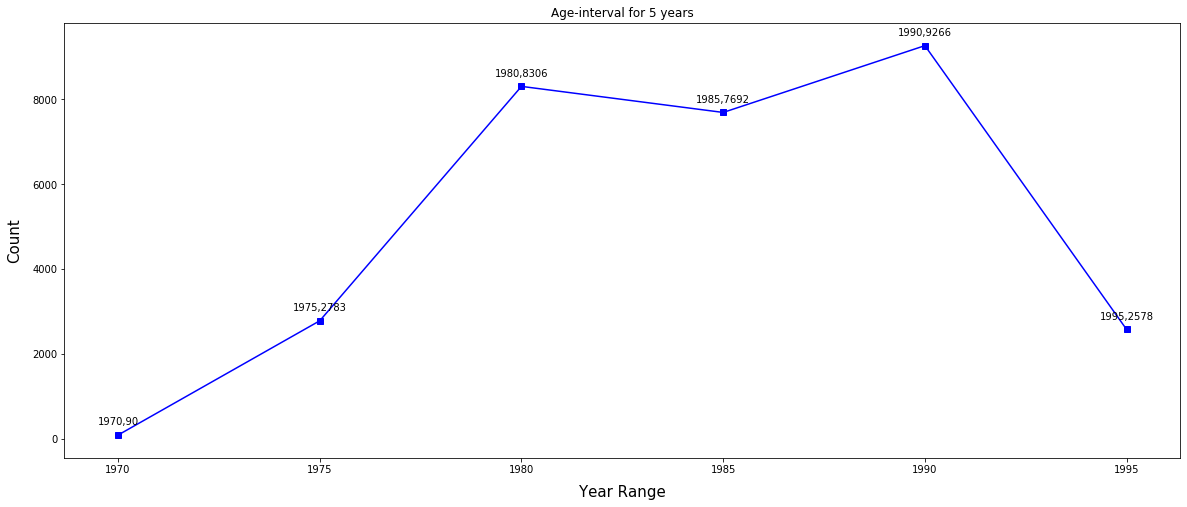

In [14]:
YearRange = []
for i in range(6, 12):
    YearRange.append(len(ethnicsdata[ethnicsdata.YearRange.apply(lambda x: x == i)]))
    
x = [1970 + x * 5 for x in range(len(YearRange))]
y = YearRange

plt.figure(figsize = (20,8))
plt.plot(x, y, 's-', color = 'b', label = "Age-Interval")
plt.title("Age-interval for 5 years")
plt.xlabel("Year Range", fontsize = 15, labelpad = 10)
plt.ylabel("Count", fontsize = 15, labelpad = 10)

plt.scatter(x, y)

for i,j in zip(x, y):

    label = "{:.0f}".format(i) + "," + "{:.0f}".format(j)
    plt.annotate(label, # this is the text
                 (i, j), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext = (0,10), # distance from text to points (x,y)
                 ha = 'center') # horizontal alignment can be left, right or center

In [15]:
# SAVE MY DATA INTO CSV FILE
ethnicsdata.to_csv('./NameData/EnglishReconcateRealTaiwan.csv', index = False)

In [15]:
# # GENERATE NEW TOTAL_LIST
# with open('./pkl_data/Totalname_list', 'wb') as handle:
#     pickle.dump(Totalname_list, handle)